## Testing performance of BOW,TF-IDF on Amazon Fine food Dataset from kaggle

## Dataset
This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. 
## Task
 
#### Input - ProductId, UserId, ProfileName, HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text 
#### Ouput- To determine whether BOW or TF-IDF performs a better vectorization.

In [6]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve,auc
from nltk.stem.porter import PorterStemmer

In [9]:
con=sqlite3.connect('database.sqlite')

In [10]:
filtered_data=pd.read_sql_query("""select * from Reviews where score!=3 """,con)

#### We classify the score(4-5) as positive and score(1-2) as negative and discard score=3

In [11]:
filtered_data

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...
525809,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
525810,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
525811,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
525812,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...


In [12]:
def partition(x):
    if x<3:
        return 'negative'
    else:
        return 'positive'

In [16]:
real_score=filtered_data['Score']
positivenegative=real_score.map(partition)
filtered_data['Score']=positivenegative

In [20]:
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,score
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,positive
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,negative
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,positive
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,negative
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1350777600,Great taffy,Great taffy at a great price. There was a wid...,positive


### Data Cleaning

In [33]:
sorted_df=filtered_data.sort_values('ProductId',axis=0,ascending=True)

In [34]:
sorted_df.shape

(525814, 10)

#### Removing duplicates for same user with text for different products on same time

In [37]:
sorted_df=sorted_df.drop_duplicates(subset={'UserId','ProfileName','Time','Text'},keep='first',inplace=False)

In [38]:
sorted_df.shape

(364173, 10)

#### Data remaining after removing duplicates = 69% (intial = 525814, now=364173)

In [41]:
final=sorted_df[sorted_df.HelpfulnessNumerator <= sorted_df.HelpfulnessDenominator]

In [42]:
final.shape

(364171, 10)

#### Helpfulness numerator is total positive reviews and helpfullness denominator is total of both +ve,-ve. so, removing redudunant rows

In [44]:
final['score'].value_counts()

positive    307061
negative     57110
Name: score, dtype: int64

### Text to vector mapping
### 1. Bag of Words

In [48]:
count_vec=CountVectorizer()
# It will convert all text to lower case by default
final_counts=count_vec.fit_transform(final['Text'].values)

In [53]:
#### final_counts is a sparse matrix represenattion
final_counts.get_shape()

(364171, 115281)

### Text-preprocessing - Stopwords,lemmatization,stemming

1. Removing HTML tags
2. Removing punctuations
3. Check for english letter and word is not alpha-numeric
4. len(words)>2
5. converting words to lowercase 
6. stemming

In [56]:
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

stop=set(stopwords.words('english'))
snow=nltk.stem.SnowballStemmer('english')

In [57]:
def clean_html(sent):
    clean=re.compile('<.*?>')
    cleantext=re.sub(clean,' ',sent)
    return cleantext

In [80]:
def cleanpunc(sent):
    cleaned=re.sub(r'[?|!|\'|"|#]',r'',sent)
    cleaned=re.sub(r'[.|,|)|(|/]',r' ',cleaned)
    return cleaned
             

In [94]:
i=0
final_string=[]
pos_words=[]
neg_words=[]
for sent in final['Text'].values:
    fil_sen=[]
    sent=clean_html(sent)
    for w in sent.split():
        for clean_words in cleanpunc(w).split():
            if((clean_words.isalpha())&(len(clean_words)>2)):
                if(clean_words.lower() not in stop):
                    s=(snow.stem(clean_words.lower())).encode('utf8')
                    fil_sen.append(s)
                    if((final['score'].values)[i]=='positive'):
                        pos_words.append(s)
                    else:
                        neg_words.append(s)
                else:
                    continue
            else:
                continue
        
    strl=b" ".join(fil_sen)
    final_string.append(strl)
    i+=1

In [88]:
final['cleaned_text']=final_string

C:\Users\vingo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [92]:
final[['Text','cleaned_text']].head()

,Text,cleaned_text
138706,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
138688,"I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
138689,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...
138690,This is a great little book to read aloud- it ...,b'great littl book read nice rhythm well good ...
138691,This is a book of poetry about the months of t...,b'book poetri month year goe month cute littl ...


### Bi-Grams and N-grams

In [96]:
# calculating freq of +ve and -ve words
freq_dist_pos=nltk.FreqDist(pos_words)
freq_dist_neg=nltk.FreqDist(neg_words)


In [97]:
print('Most common +ve words',freq_dist_pos.most_common(20))
print('Most common -ve words',freq_dist_neg.most_common(20))

Most common +ve words [(b'like', 139429), (b'tast', 129047), (b'good', 112766), (b'flavor', 109624), (b'love', 107357), (b'use', 103888), (b'great', 103870), (b'one', 96726), (b'product', 91033), (b'tri', 86791), (b'tea', 83888), (b'coffe', 78814), (b'make', 75107), (b'get', 72125), (b'food', 64802), (b'would', 55568), (b'time', 55264), (b'buy', 54198), (b'realli', 52715), (b'eat', 52004)]
Most common -ve words [(b'tast', 34585), (b'like', 32330), (b'product', 28218), (b'one', 20569), (b'flavor', 19575), (b'would', 17972), (b'tri', 17753), (b'use', 15302), (b'good', 15041), (b'coffe', 14716), (b'get', 13786), (b'buy', 13752), (b'order', 12871), (b'food', 12754), (b'dont', 11877), (b'tea', 11665), (b'even', 11085), (b'box', 10844), (b'amazon', 10073), (b'make', 9840)]


#### Considering bigram,trigram,ngram because of overlap of words frokm positive and negative freq dist eg. like occured both in +ve and -ve reviews

In [98]:
count_vec=CountVectorizer(ngram_range=(1,2))
final_counts=count_vec.fit_transform(final['Text'].values)

In [99]:
final_counts.get_shape()

(364171, 2910192)

#### After calculating bigrams dimensions increased from (364171, 115281) to (364171, 2910192)

### TF-IDF

In [100]:
tf_vec=TfidfVectorizer(ngram_range=(1,2))
final_tf_idf=tf_vec.fit_transform(final['Text'].values)

In [101]:
final_tf_idf.get_shape()

(364171, 2910192)

In [103]:
features=tf_vec.get_feature_names()

In [105]:
features[10000:10009]

['14 count',
 '14 country',
 '14 crackers',
 '14 credit',
 '14 crude',
 '14 cup',
 '14 cupcakes',
 '14 cups',
 '14 currants']

In [108]:
def top_tfidf_features(rows,features,top_n=25):
    top_ids=np.argsort(rows)[::-1][:top_n]
    top_feat=[(features[i],rows[i]) for i in top_ids]
    df=pd.DataFrame(top_feat)
    df.columns=['features','tfidf']
    return df
top_idf=top_tfidf_features(final_tf_idf[1,:].toarray()[0],features,25)

In [109]:
top_idf

,features,tfidf
0,sendak books,0.173437
1,rosie movie,0.173437
2,paperbacks seem,0.173437
3,cover version,0.173437
4,these sendak,0.173437
5,the paperbacks,0.173437
6,pages open,0.173437
7,really rosie,0.168074
8,incorporates them,0.168074
9,paperbacks,0.168074


### Word2Vector

In [117]:
import gensim
i=0
list_sent=[]
for sent in final['Text'].values:
    fil_sen=[]
    sent=clean_html(sent)
    for w in sent.split():
        for clean_words in cleanpunc(w).split():
            if((clean_words.isalpha())):
                fil_sen.append(clean_words)
            else:
                continue
    list_sent.append(fil_sen)
                

In [118]:
print(final['Text'].values[0])
print("******************************************************")
print(list_sent[0])

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
******************************************************
['this', 'witty', 'little', 'book', 'makes', 'my', 'son', 'laugh', 'at', 'loud', 'i', 'recite', 'it', 'in', 'the', 'car', 'as', 'were', 'driving', 'along', 'and', 'he', 'always', 'can', 'sing', 'the', 'refrain', 'hes', 'learned', 'about', 'whales', 'India', 'drooping', 'i', 'love', 'all', 'the', 'new', 'words', 'this', 'book', 'introduces', 'and', 'the', 'silliness', 'of', 'it', 'all', 'this', 'is', 'a', 'classic', 'book', 'i', 'am', 'willing', 'to', 'bet', 'my', 'son', 'will', 'STILL', 'be', 'able', 'to', 'recite', 'from', 'memory', 'when', 'he', 'is', 'in', 'co

In [119]:
# min_count indicates words with min 5 occurances and construct a vector
# size - dimensions of vectors to be constructed.(more corpus, size should be high)
# workers - for using cores in cpu
w2v_model=gensim.models.Word2Vec(list_sent,min_count=5,size=50,workers=4)

In [121]:
words=list(w2v_model.wv.vocab)
print(len(words))

44605


In [122]:
w2v_model.wv.most_similar('tasty')

[('tastey', 0.9088196754455566),
 ('yummy', 0.8999543190002441),
 ('delicious', 0.8533775806427002),
 ('satisfying', 0.8513847589492798),
 ('filling', 0.8383749723434448),
 ('flavorful', 0.8172611594200134),
 ('addicting', 0.7911904454231262),
 ('versatile', 0.7908523082733154),
 ('tasteful', 0.786931574344635),
 ('delish', 0.7791372537612915)]

### Performing TSNE dimensionality reduction for BOW vectors

In [127]:
from sklearn.manifold import TSNE
model=TSNE(n_components=2,random_state=0)
# default perpexity=30 (neighbourhood selection distance)
# default learning rate=200
# default iterations=1000
tsne_data=model.fit_transform(final_counts[0:15000,:])

In [130]:
print(tsne_data.shape)
new_cord=np.vstack((tsne_data.T,final['score'][0:15000])).T
print(new_cord.shape)

(15000, 2)
(15000, 3)


In [131]:
data_frame=pd.DataFrame(data=new_cord,columns=("1st pca","2nd pca","labels"))
print(data_frame.head())

   1st pca   2nd pca    labels
0   11.578   5.94768  positive
1 -5.67428  -5.78454  positive
2 -6.02172 -0.429541  positive
3 -8.26183   5.15704  positive
4 -6.20638 -0.250878  positive


C:\Users\vingo\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


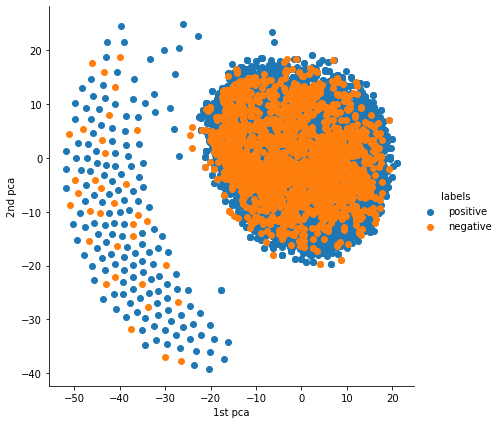

In [132]:
import seaborn as sns
sns.FacetGrid(data_frame,hue='labels',size=6).map(plt.scatter,'1st pca','2nd pca').add_legend()
plt.show()

### Performing TSNE dimensionality reduction for TFIDF vectors

In [133]:
from sklearn.manifold import TSNE
model=TSNE(n_components=2,random_state=0)
# default perpexity=30 (neighbourhood selection distance)
# default learning rate=200
# default iterations=1000
tsne_data=model.fit_transform(final_tf_idf[0:15000,:])

In [136]:
print(tsne_data.shape)
new_cord=np.vstack((tsne_data.T,final['score'][0:15000])).T
print(new_cord.shape)

(15000, 2)
(15000, 3)


In [137]:
data_frame=pd.DataFrame(data=new_cord,columns=("1st pca","2nd pca","labels"))
print(data_frame.head())

   1st pca  2nd pca    labels
0 -54.9612  27.0013  positive
1  -58.063  23.4704  positive
2 -55.4823  26.7363  positive
3 -56.2794   27.021  positive
4 -55.3176  26.9854  positive


C:\Users\vingo\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


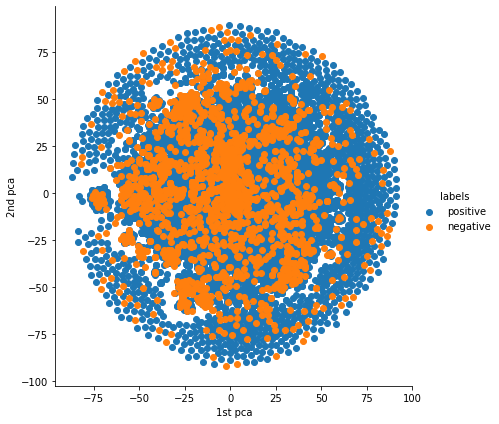

In [138]:
import seaborn as sns
sns.FacetGrid(data_frame,hue='labels',size=6).map(plt.scatter,'1st pca','2nd pca').add_legend()
plt.show()

### Observations

TF-IDF performed a better classification than bag of words vectors in terms of classification of +ve,-ve reviews